# GRU Attention Model

In [1]:
import numpy as np
import pickle
import time
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from lstm_data_prep import numpy_prep
from eval_model import epoch_time, find_lens, accuracy

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class GRUAttention(nn.Module):
    def __init__(self, n_input, n_hidden, n_out, seq_len, drop):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.num_gru_layers = 1

        super().__init__()
        self.dropout = nn.Dropout(drop)
        self.gru = nn.GRU(input_size=n_input, hidden_size=n_hidden, num_layers=1, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_out)

        self.fc_h = nn.Linear(n_hidden, n_hidden, bias=False)
        self.fc_out = nn.Linear(n_hidden, n_hidden, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(n_hidden))

    def forward(self, x, x_lens, h):
        batch_size = x.shape[0]

        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        
        out, hidden = self.gru(x_packed, h)
    
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True, padding_value=0)

        out = self.dropout(out)
        # attention
        # (batch_size, seq_len, seq_len)
        e = torch.zeros((batch_size, out.shape[1], out.shape[1]), device=device)
        V = self.weight.repeat(batch_size, 1).unsqueeze(1)
        for i in range(out.shape[1]):
            r = torch.zeros(out.shape, device=device)
            for j in range(out.shape[1]):
                # (batch_size, seq_len, hidden_size)
                z = torch.tanh(self.fc_h(out[:, i, :]) + self.fc_out(out[:, j, :]))
                r[:, j, :] = z
            r = r.permute(0, 2, 1)
            
            a = torch.bmm(V, r).squeeze(1)
            e[:, i, :] = a
        att_weights = F.log_softmax(e, dim=-1)

        context_vector = torch.bmm(att_weights, out)
        
        y_hat = self.fc(context_vector)
        return y_hat

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_gru_layers, batch_size, self.n_hidden, device=device)

In [3]:
class GRUModel:
    def __init__(self, model, loss_fn, optimizer, seq_len):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.seq_len = seq_len

    def train(self, train_loader, n_epochs=10, learning=1e-2):
        train_loss = []
        best_loss = 1e10

        self.model.train()
        for i in range(n_epochs):
            start = time.time()
            avg_loss = 0.
            for X, y in train_loader:
                loss = 0.
                curr_batch_size = X.shape[0]
                h = self.model.init_hidden(curr_batch_size)
                X, y = X.to(device), y.to(device)
                self.optimizer.zero_grad()

                X_lens = find_lens(X)

                output = self.model(X, X_lens, h)

                out = output.permute(0, 2, 1)
                target = y.permute(0, 2, 1)

                loss += self.loss_fn(out, target)
                
                loss.backward()
                self.optimizer.step()
                avg_loss += loss.item()

            end = time.time()
            epoch_mins, epoch_secs = epoch_time(start, end)
            if best_loss > avg_loss:
                best_loss = avg_loss
                torch.save({"gru_attention": self.model.state_dict(), "gru_att_optimizer": self.optimizer.state_dict()}, 'gru-attention-model.pt')

            print("Epoch " + str(i + 1) + "/" + str(n_epochs))
            print("Time: " + str(epoch_mins) + " minutes " + str(epoch_secs) + " seconds")
            print("Training loss: " + str(avg_loss))
            print()
            train_loss.append(avg_loss)
        return train_loss
    
    def eval(self, x, y):
        check = torch.load("gru-attention-model.pt")
        self.model.load_state_dict(check["gru_attention"])
        self.optimizer.load_state_dict(check["gru_att_optimizer"])

        with torch.no_grad():
            correct = np.zeros(self.seq_len)
            total = np.zeros(self.seq_len)
            self.model.eval()
            loss = 0.
            curr_batch_size = x.shape[0]
            h = self.model.init_hidden(curr_batch_size)
            X, Y = x.to(device), y.to(device)
            
            X_lens = find_lens(X)

            out = self.model(X, X_lens, h)

            top_value, top_index = out.topk(1)

            final = torch.zeros(y.shape).to(device)
            for clip in range(y.shape[0]):
                for step in range(y.shape[1]):
                    final[clip][step][top_index[clip][step]] = 1
                
            correct, total = accuracy(y.cpu().numpy(), final.cpu().numpy(), correct, total)
        
        ff_accuracy = correct / total
        return ff_accuracy, loss
    
    def random_samples(self, X, pad=0.):
        X_random = []
        X_lens = find_lens(X)
        for i in range(X.shape[0]):
            X_batch = np.random.normal(size=(X_lens[i], X.shape[-1]))
            if X_lens[i] < self.seq_len:
                X_pad = np.array([[pad]*X.shape[-1]]*(self.seq_len - X_lens[i]))
                X_batch = np.append(X_batch, X_pad, axis=0)
            X_random.append(X_batch)
        X_random = np.array(X_random)
        return X_random
    
    def rand_test(self, X, y_test, n_samples=20, percentile=90):
        rand_acc_array = []
        for sample in range(n_samples):
            X_random = torch.from_numpy(self.random_samples(X)).float().to(device)
            gru_rand_acc, _ = self.eval(X_random, y_test)
            rand_acc_array.append(gru_rand_acc)
        plot = np.percentile(np.sort(np.array(rand_acc_array), axis=0), percentile, axis=0)
        return plot

In [4]:
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)

X_train, y_train, X_t, y_t = numpy_prep(TS, pad = 0.)
batch_size = 32

train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

X_test = torch.from_numpy(X_t).float().to(device)
y_test = torch.from_numpy(y_t).float().to(device)

c:\Users\Anna\Documents\GitHub\srp-lab-notebook\hcp_data\lstm_data_prep.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_padded = paddingArr(np.array(X_arr), pad=pad)


In [5]:
n_input = 300
n_hidden = 32
n_out = 15
seq_len = 90
drop = 0.1
EPOCHS = 15
learning_rate = 2e-3

gru_attention = GRUAttention(n_input, n_hidden, n_out, seq_len, drop).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_attention.parameters(), lr=learning_rate)

model = GRUModel(gru_attention, loss_fn, optimizer, seq_len)

In [6]:
train_loss = model.train(train_loader, n_epochs=EPOCHS, learning=learning_rate)

Epoch 1/15
Time: 23 minutes 2 seconds
Training loss: 1150.190538406372

Epoch 2/15
Time: 31 minutes 33 seconds
Training loss: 212.35464516282082

Epoch 3/15
Time: 31 minutes 20 seconds
Training loss: 111.98589664325118

Epoch 4/15
Time: 31 minutes 26 seconds
Training loss: 60.836203437931545

Epoch 5/15
Time: 30 minutes 54 seconds
Training loss: 35.63492381286551

Epoch 6/15
Time: 31 minutes 29 seconds
Training loss: 22.67644791306555

Epoch 7/15
Time: 24 minutes 39 seconds
Training loss: 15.429812059300641

Epoch 8/15
Time: 30 minutes 54 seconds
Training loss: 17.52004030515151

Epoch 9/15
Time: 31 minutes 12 seconds
Training loss: 27.502825306720077

Epoch 10/15
Time: 31 minutes 35 seconds
Training loss: 17.35996262261215

Epoch 11/15
Time: 30 minutes 39 seconds
Training loss: 43.69726203688299

Epoch 12/15
Time: 29 minutes 14 seconds
Training loss: 53.0432640068193

Epoch 13/15
Time: 26 minutes 13 seconds
Training loss: 67.22272726829512

Epoch 14/15
Time: 25 minutes 36 seconds
Trai

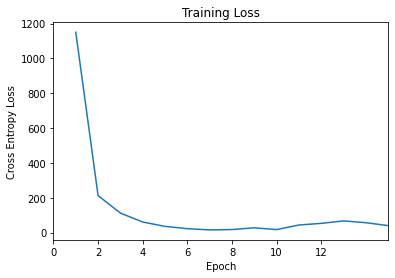

In [9]:
xAx = [i for i in range(1, EPOCHS+1)]
plt.plot(xAx, train_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlim(0, EPOCHS)
plt.xticks([2*j for j in range(EPOCHS // 2)])
plt.title("Training Loss")
plt.show()

In [10]:
gru_attention_acc, loss = model.eval(X_test, y_test)
%store gru_attention_acc

Stored 'gru_attention_acc' (ndarray)


In [39]:
gru_rand_acc = model.rand_test(X_test, y_test)

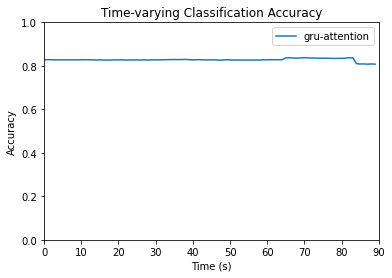

In [12]:
xAx = [i for i in range(0,90)]
plt.plot(xAx, gru_attention_acc, label="gru-attention")
#plt.plot(xAx, gru_rand_acc, label="random")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlim(0,90)
plt.title("Time-varying Classification Accuracy")
plt.legend()
plt.show()